<h1>IBM Data Science Capstone Project</h1>

### Imports

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
import re
import json
import ipywidgets as widgets
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib notebook

### Web Scraping and Data Preparation
Get the list of all the neighbourhoods in Mumbai

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table', class_='wikitable sortable')
temp_df = pd.read_html(str(table))
df = temp_df[0]
# The coordinates of Nehru Nagar and Hindu Colony were incorrect on Wikipedia 
df.loc[41, 'Latitude'] = 19.0640
df.loc[41, 'Longitude'] = 72.8826
df.loc[82, 'Latitude'] = 19.0197
df.loc[82, 'Longitude'] = 72.8479
df.head()

,Area,Location,Latitude,Longitude
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270


All the Suburbs of Mumbai

In [3]:
df['Location'].unique()

array(['Andheri,Western Suburbs', 'Western Suburbs',
       'Mira-Bhayandar,Western Suburbs', 'Bandra,Western Suburbs',
       'Borivali (West),Western Suburbs', 'Goregaon,Western Suburbs',
       'Kandivali West,Western Suburbs', 'Kandivali East,Western Suburbs',
       'Khar,Western Suburbs', 'Malad,Western Suburbs',
       'Sanctacruz,Western Suburbs', 'Vasai,Western Suburbs',
       'Vile Parle,Western Suburbs', 'Eastern Suburbs',
       'Ghatkopar,Eastern Suburbs', 'Kurla,Eastern Suburbs',
       'Mulund,Eastern Suburbs', 'Powai,Eastern Suburbs',
       'Harbour Suburbs', 'Govandi,Harbour Suburbs',
       'Trombay,Harbour Suburbs', 'South Mumbai',
       'Antop Hill,South Mumbai', 'Byculla,South Mumbai',
       'Colaba,South Mumbai', 'Dadar,South Mumbai', 'Fort,South Mumbai',
       'Kalbadevi,South Mumbai', 'Kamathipura,South Mumbai',
       'Tardeo,South Mumbai', 'Mumbai'], dtype=object)

In [4]:
for i, l in enumerate(df['Location']):
    x = l.split(",")
    if len(x) == 2:
        df.loc[i, 'Location'] = x[1]
    else:
        df.loc[i, 'Location'] = x[0]
df.head()

,Area,Location,Latitude,Longitude
0,Amboli,Western Suburbs,19.129300,72.843400
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,Western Suburbs,19.124085,72.831373
3,Four Bungalows,Western Suburbs,19.124714,72.827210
4,Lokhandwala,Western Suburbs,19.130815,72.829270


Get the list of all the restaurants in Mumbai using Zomato

In [18]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36','Accept-Encoding': 'gzip, deflate, br','Accept-Language': 'en-US,en;q=0.9,hi;q=0.8'}
url = r'https://www.zomato.com/mumbai/restaurants?page='


def scrap(u, number, h):
    output = list()
    query = u + str(number)
    #print(query)
    page = requests.get(query, headers = h)
    soup = BeautifulSoup(page.text, 'lxml')
    matches = soup.find_all('article', class_='search-result')
    for match in matches:
        try:
            inr = 0
            try:
                name = match.find('a', class_ = 'result-title hover_feedback zred bold ln24 fontsize0').text.strip()
            except:
                name = np.nan
            try:
                dining_rating = match.find_all('span', class_='rating-value')[0].text
            except:
                dining_rating = np.nan
            try:
                dining_votes = match.find_all('span', class_='review-count')[0].text
            except:
                dining_votes = np.nan
            try:
                delivery_rating = match.find_all('span', class_='rating-value')[1].text
            except:
                delivery_rating = np.nan
            try:
                delivery_votes = match.find_all('span', class_='review-count')[1].text
            except:
                delivery_votes = np.nan
            
            try:
                line7 = match.find('div', class_ = 'search-page-text clearfix row')

                cost = line7.find_all('span', 'col-s-11 col-m-12 pl0')
                for value in cost:
                    try:
                        inr = value.text
                    except:
                        inr = np.nan
            except:
                inr = np.nan
                
            
            output.append([name, inr, dining_rating, dining_votes, delivery_rating, delivery_votes])
        except:
            raise ValueError('Data Read Error!')
    return output


my_list = list()
for i in range(1, 1532):
    reception = scrap(url, i, headers)
    my_list.append(reception)

restaurants = list()
    
for ls in my_list:
    for values in ls:
        restaurants.append(values)


column_names = ['Name', 'Cost for 2', 'Dining_rating', 'Dining_votes', 'Delivery_rating', 'Delivery_votes']        
mumbaires = pd.DataFrame(restaurants, columns = column_names)
#mumbaires.to_csv('ZomatoFinal.csv')

In [5]:
zomato = pd.read_csv("ZomatoFinal.csv")

In [6]:
zomato.head()

,Unnamed: 0,Name,Cost for 2,Dining_rating,Dining_votes,Delivery_rating,Delivery_votes
0,0,Yasin's Food Inn,₹700,4.1,"(2,182)",3.8,(99.4K)
1,1,McDonald's,₹400,4.0,(948),4.1,(11.4K)
2,2,Joey's Pizza,₹800,4.8,"(8,922)",4.2,"(4,081)"
3,3,Guru Kripa,₹300,4.6,"(3,671)",4.2,(21.5K)
4,4,Cafe Safar,₹600,4.1,"(2,174)",3.9,(89.1K)


In [7]:
# Data Cleaning
i=0
for c, di, de in zip(zomato['Cost for 2'], zomato['Dining_votes'], zomato['Delivery_votes']):
    try:
        cost = r'([0-9]*)'
        zomato.loc[i, 'Cost for 2'] = re.findall(cost, c)[1]
    except:
        zomato.loc[i, 'Cost for 2'] = np.nan
    try:
        dining = r'([0-9A-Z,.]*)'
        zomato.loc[i, 'Dining_votes'] = re.findall(dining, di)[1]
    except:
        zomato.loc[i, 'Dining_votes'] = np.nan
    try:
        delivery = r'([0-9A-Z,.]*)'
        zomato.loc[i, 'Delivery_votes'] = re.findall(delivery, de)[1]
    except:
        zomato.loc[i, 'Delivery_votes'] = np.nan
    i += 1

In [8]:
zomato['Dining_votes'] = zomato['Dining_votes'].str.replace(",", "")
zomato['Delivery_votes'] = zomato['Delivery_votes'].str.replace(",", "")

In [9]:
# Data Cleaning
i=0
for di, de in zip(zomato['Dining_votes'], zomato['Delivery_votes']):
    x = r'([A-Z])'
    try:
        try:
            if di != np.nan:
                if len(re.findall(x, di)) != 0:
                    di = float(di.replace("K", ""))
                    di = di*1000
                    zomato.loc[i, 'Dining_votes'] = di
        except:
            pass
        try:
            if de != np.nan:
                if len(re.findall(x, de)) != 0:
                    de = float(de.replace("K", ""))
                    de = de*1000
                    zomato.loc[i, 'Delivery_votes'] = de
        except:
            pass
    except:
        pass
    i+=1
                

In [16]:
zomato['Dining_votes'] = zomato['Dining_votes'].astype(float)
zomato['Delivery_votes'] = zomato['Delivery_votes'].astype(float)
zomato.drop('Unnamed: 0', axis=1, inplace=True)

In [10]:
zomato['Cost for 2'] = zomato['Cost for 2'].replace("", np.nan)
zomato['Cost for 2'] = zomato['Cost for 2'].replace("1", np.nan)
zomato['Cost for 2'] = zomato['Cost for 2'].replace("2", np.nan)
zomato['Cost for 2'] = zomato['Cost for 2'].replace("3", np.nan)
zomato['Cost for 2'] = zomato['Cost for 2'].replace("4", np.nan)
zomato['Cost for 2'] = zomato['Cost for 2'].replace("5", np.nan)
zomato['Cost for 2'] = zomato['Cost for 2'].replace("6", np.nan)
zomato['Cost for 2'] = zomato['Cost for 2'].replace("7", np.nan)
zomato['Cost for 2'] = zomato['Cost for 2'].astype(float)
zomato['Cost for 2'].unique()

array([700., 400., 800., 300., 600., 650., 900., 200., 450., 500.,  nan,
       750., 250., 550., 350., 150., 100., 950., 850., 120.,  50.,  10.,
       340., 720., 580., 248.,  30., 270.,  60., 260., 180., 175., 360.])

In [13]:
# Cleaned Dataset
zomato['Cost for 2'].replace(np.nan, np.mean(zomato['Cost for 2']), inplace=True)
zomato['Dining_rating'].replace(np.nan, np.mean(zomato['Dining_rating']), inplace=True)
zomato['Delivery_rating'].replace(np.nan, np.mean(zomato['Delivery_rating']), inplace=True)
zomato.head()

,Unnamed: 0,Name,Cost for 2,Dining_rating,Dining_votes,Delivery_rating,Delivery_votes
0,0,Yasin's Food Inn,700.0,4.1,2182,3.8,99400
1,1,McDonald's,400.0,4.0,948,4.1,11400
2,2,Joey's Pizza,800.0,4.8,8922,4.2,4081
3,3,Guru Kripa,300.0,4.6,3671,4.2,21500
4,4,Cafe Safar,600.0,4.1,2174,3.9,89100


In [17]:
zomato.dtypes

Name                object
Cost for 2         float64
Dining_rating      float64
Dining_votes       float64
Delivery_rating    float64
Delivery_votes     float64
dtype: object

In [18]:
zomato = zomato.groupby('Name', as_index=False, sort=False).agg({'Cost for 2': np.mean, 'Dining_rating': np.mean, 'Dining_votes': np.sum, 'Delivery_rating': np.mean, 'Delivery_votes': np.sum})
zomato.head()

,Name,Cost for 2,Dining_rating,Dining_votes,Delivery_rating,Delivery_votes
0,Yasin's Food Inn,700.0,4.100000,2182.0,3.800000,99400.0
1,McDonald's,400.0,4.000000,948.0,4.100000,11400.0
2,Joey's Pizza,800.0,4.800000,8922.0,4.200000,4081.0
3,Guru Kripa,300.0,4.600000,3671.0,4.200000,21500.0
4,Cafe Safar,450.0,3.798814,2174.0,3.762386,89100.0


Number of Neighbourhoods in each Suburb

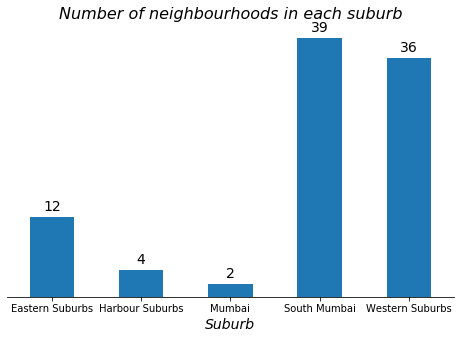

In [19]:
neigh = df.groupby('Location')['Area'].count()
plt.figure(figsize=(8, 5))
ax = neigh.plot(kind='bar')
plt.title("Number of neighbourhoods in each suburb", fontsize=16, fontstyle='italic')
plt.xlabel("Suburb", fontsize=14, fontstyle='italic')
plt.xticks(rotation=0)
for p in ax.patches:
    ax.annotate(np.round(p.get_height(), decimals=2),
           (p.get_x()+p.get_width()/2, p.get_height()),
           ha='center', va='center', xytext=(0,10), textcoords='offset points', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.yticks([])

plt.show()

### Coordinates of Mumbai


In [20]:
geo_locator = Nominatim(user_agent='user-agent')
location = geo_locator.geocode("Mumbai")
latitude = location.latitude
longitude = location.longitude
print(f"Coordinates of Mumbai: {latitude}, {longitude}")

Coordinates of Mumbai: 19.0759899, 72.8773928


Show the neighbourhoods of Mumbai on the Map

In [21]:
mumbai = folium.Map(location=[latitude, longitude], zoom_start=10)
colours = {'Eastern Suburbs': 'red', 'Harbour Suburbs': 'blue', 'Mumbai': 'yellow', 'South Mumbai': 'green', 'Western Suburbs': 'purple'}
for lat, long, a, loca in zip(df['Latitude'], df['Longitude'], df['Area'], df['Location']):
    folium.CircleMarker(
        [lat, long],
        radius=4,
        color=colours[loca],
        fill=True,
        fill_color=colours[loca],
        fill_opacity=0.5,
        popup=folium.Popup('{}'.format(a), parse_html=True)
    ).add_to(mumbai)
mumbai

### FourSquare API
Foursquare API Credentials

In [22]:
# @hidden_cell
login = pd.read_csv("login.csv")
CLIENT_ID = login['CLIENT_ID'].values[0]
CLIENT_SECRET = login['CLIENT_SECRET'].values[0]
VERSION = login['VERSION'].values[0]

Exploring the nearby restaurants of the first Neighbourhood

In [23]:
first = df.loc[0, 'Area']
lat = df.loc[0, 'Latitude']
lng = df.loc[0, 'Longitude']
print(f"Neighborhood : {first}\nLatitude : {lat}\nLongitude: {lng}")

Neighborhood : Amboli
Latitude : 19.1293
Longitude: 72.8434


##### API request<br>
The following request will return top 100 nearby venues within a radius of 3000 meters

In [24]:
LIMIT = 100
radius = 3000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    lng, 
    radius, 
    LIMIT)

In [25]:
res = requests.get(url).json()
res

{'meta': {'code': 200, 'requestId': '5f231e42932b2b7420c0ec0f'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Mumbai',
  'headerFullLocation': 'Mumbai',
  'headerLocationGranularity': 'city',
  'totalResults': 220,
  'suggestedBounds': {'ne': {'lat': 19.15630002700003,
    'lng': 72.87192470770358},
   'sw': {'lat': 19.102299972999973, 'lng': 72.81487529229642}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b0587e2f964a52095a522e3',
       'name': 'Merwans Cake shop',
       'location': {'address': 'Near Andheri Station, SV Road',
        'crossStreet': 'Andheri West',
        'lat': 19.119300215885474,
        'lng': 72.84541776016009,
        'labeledLatLngs': [{'label': '

In [26]:
# This function returns the category of each venue
def get_category(row):
    try:
        category = row['categories']
    except:
        category = row['venue.categories']
    if len(category) == 0:
        return None
    else:
        return category[0]['name']

Converting the json data to a Dataframe and applying get_category()

In [27]:
venues = res['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
cols = ['venue.name', 'venue.categories', 'venue.location.address', 'venue.location.crossStreet', 'venue.location.distance','venue.location.lat', 'venue.location.lng', 'venue.id']
nearby_venues = nearby_venues.loc[:, cols]
nearby_venues['venue.categories'] = nearby_venues.apply(get_category, axis=1)
nearby_venues

,venue.name,venue.categories,venue.location.address,venue.location.crossStreet,venue.location.distance,venue.location.lat,venue.location.lng,venue.id
0,Merwans Cake shop,Bakery,"Near Andheri Station, SV Road",Andheri West,1133,19.119300,72.845418,4b0587e2f964a52095a522e3
1,Shawarma Factory,Falafel Restaurant,Dadabhai Road,"Off JP Road, Near Navrang Cinema",611,19.124591,72.840398,5174e2be498e39cf0d1c20cb
2,Jaffer Bhai's Delhi Darbar,Mughlai Restaurant,Jogeshwari West,NaN,973,19.137714,72.845909,55fc3615498e141bd45da525
3,Hard Rock Cafe Andheri,American Restaurant,"Sharyans Audeus, Ground Floor, Diagonally Opp....",Veera Desai Rd.,1129,19.135995,72.835335,51fa1f52ccdae6540ad807b4
4,Pizza Express,Pizza Place,Crystal Paradise,"Off Veera Desai, Andheri",962,19.131893,72.834668,52b3fe27498e991e4fe996cb
5,Joey's Pizza,Pizza Place,"6 & 7, Upvan Bldg, Behind Indian Oil Colony, D...",Andheri,1437,19.126762,72.830001,4cc1d37c3d7fa1cd0de39a5f
6,Doolally Taproom,Brewery,Dalia Estate,Off New Link Road,1310,19.135917,72.833094,56433c85498ee4d7ac3bca83
7,Narayan Sandwich,Sandwich Place,Near Chinai College,Nagardas Road,1138,19.121398,72.850270,4df9c1b3b3ad7391e9c7bf07
8,Mainland China,Chinese Restaurant,Off New Link Road,NaN,1357,19.140391,72.838033,4b0587d6f964a520bca322e3
9,The Little Door,Pub,"Plot No. B 31, Ground Floor - Shree Siddhivana...","Off New Link Road, Andheri West,",1544,19.139265,72.833180,4f4e4c34e4b027c8742327cf


Extracting the nearby Restaurants (Categories that have the word 'Restaurant' in it)

In [28]:
# Creating a copy of above dataframe 
a = nearby_venues.copy()

# A dataframe which will store the data of nearby restaurants
restaurants = pd.DataFrame([], columns=['Name', 'Category', 'Address', 'Street', 'Distance', 'Latitude', 'Longitude', 'Id'])
restaurants

,Name,Category,Address,Street,Distance,Latitude,Longitude,Id


In [29]:
p = r'([a-zA-Z]* (Restaurant))'
for name, cat, add, street, dist, lat, lng, i_d in zip(a['venue.name'],a['venue.categories'],a['venue.location.address'],a['venue.location.crossStreet'],a['venue.location.distance'],a['venue.location.lat'],a['venue.location.lng'],a['venue.id']):
    if re.findall(p, cat):
        temp = {'Name': [name], 'Category': [cat], 'Address': [add], 'Street': [street], 'Distance': [dist],'Latitude': [lat], 'Longitude': [lng], 'Id': [i_d]}
        temp = pd.DataFrame(temp)
        restaurants = restaurants.append(temp)

In [30]:
restaurants.reset_index(drop=True, inplace=True)

In [31]:
restaurants = restaurants.sort_values(by=['Distance'])
restaurants.reset_index(drop=True, inplace=True)
restaurants.head()

,Name,Category,Address,Street,Distance,Latitude,Longitude,Id
0,Shawarma Factory,Falafel Restaurant,Dadabhai Road,"Off JP Road, Near Navrang Cinema",611,19.124591,72.840398,5174e2be498e39cf0d1c20cb
1,Garden Court,Indian Restaurant,"Opp. Andheri Sports Complex, Andheri",JP Rd.,665,19.127188,72.837478,4b46128bf964a520751526e3
2,Shetty's Corner,Chinese Restaurant,Bhavan's College,NaN,765,19.124845,72.837858,4df24b2cd1649c8a28de604e
3,Persia Darbar,Indian Restaurant,Jogeshwari West,S.V. Road,924,19.136952,72.846822,5247116c11d2982261defb5d
4,Jaffer Bhai's Delhi Darbar,Mughlai Restaurant,Jogeshwari West,NaN,973,19.137714,72.845909,55fc3615498e141bd45da525


In [32]:
#Category and Count of each Category
temp = restaurants.groupby('Category')['Name'].count()
temp

Category
American Restaurant               2
Asian Restaurant                  1
Bengali Restaurant                1
Chinese Restaurant                5
Comfort Food Restaurant           1
Falafel Restaurant                1
Fast Food Restaurant              1
Indian Restaurant                16
Italian Restaurant                2
Mediterranean Restaurant          1
Mexican Restaurant                1
Mughlai Restaurant                1
Seafood Restaurant                1
South Indian Restaurant           1
Vegetarian / Vegan Restaurant     2
Name: Name, dtype: int64

### Restaurants near the selected location

In [33]:
def get_restaurants(lat, lng):
    LIMIT = 100
    radius = 10000
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    lng, 
    radius, 
    LIMIT)
    
    res = requests.get(url).json()

    venues = res['response']['groups'][0]['items']
    nearby_venues = json_normalize(venues)
    cols = ['venue.name', 'venue.categories', 'venue.location.address', 'venue.location.crossStreet', 'venue.location.distance','venue.location.lat', 'venue.location.lng', 'venue.id']
    nearby_venues = nearby_venues.loc[:, cols]
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category, axis=1)

    a = nearby_venues.copy()
    
    restaurants = pd.DataFrame([], columns=['Name', 'Category', 'Address1', 'Address2', 'Distance(m)', 'Latitude', 'Longitude', 'Id'])

    p = r'([a-zA-Z]* (Restaurant))'
    for name, cat, add, street, dist, lat, lng, i_d in zip(a['venue.name'],a['venue.categories'],a['venue.location.address'],a['venue.location.crossStreet'],a['venue.location.distance'],a['venue.location.lat'],a['venue.location.lng'],a['venue.id']):
        if re.findall(p, cat):
            temp = {'Name': [name], 'Category': [cat], 'Address1': [add], 'Address2': [street], 'Distance(m)': [dist],'Latitude': [lat], 'Longitude': [lng], 'Id': [i_d]}
            temp = pd.DataFrame(temp)
            restaurants = restaurants.append(temp)
    
    restaurants.reset_index(drop=True, inplace=True)
    restaurants = restaurants.sort_values(by=['Distance(m)'])
    restaurants.reset_index(drop=True, inplace=True)
    
    return restaurants

In [34]:
# Dropdown menu to select the location
n = widgets.Dropdown(
    options=list(sorted(df['Area'].values)),
    description='Area:',
    disabled=False,
)
n


Dropdown(description='Area:', options=('Aarey Milk Colony', 'Agripada', 'Altamount Road', 'Amboli', 'Amrut Nag…

In [35]:
neighbourhood = n.value
lat = df[df['Area'] == neighbourhood]['Latitude'].values[0]
lng = df[df['Area'] == neighbourhood]['Longitude'].values[0]
try:
    rest = get_restaurants(lat, lng)
except:
    rest = 'Change Radius'

In [36]:
rest

,Name,Category,Address1,Address2,Distance(m),Latitude,Longitude,Id
0,Lamba Da Dhaba,Punjabi Restaurant,"V N Purav Marg, Chembur",sion trombay road,594,19.052602,72.899391,4bc201084cdfc9b6fb589521
1,Sadguru Juice and Snacks,Indian Restaurant,NG Acharya Road,NaN,1423,19.062191,72.900538,4b0587ccf964a52024a222e3
2,The Royal Orchid,Asian Restaurant,NaN,NaN,1437,19.061739,72.901596,4dc657591f6ef43b8a2cdf4a
3,The Golden Wok,Chinese Restaurant,"Chembur, Mumbai, Maharashtra",NaN,1704,19.049959,72.910161,4f12fca4e4b0042055f1c055
4,Mani's Lunch Home's Satvika,Indian Restaurant,Vikrant Circle,Ghatkopar East,2922,19.075220,72.904728,50695f53e4b0c7c052fa80a1
5,Guru Kripa,Indian Restaurant,"Guru Kripa Building, Near SIES College",Rd No 24,3504,19.042955,72.861796,4b0587d8f964a52008a422e3
6,Tewari Sweets & Fast Foods,Indian Restaurant,"Sulochana Shetty Rd,",Sion West,4121,19.035653,72.858353,4dada3416e81d745d745ae5c
7,Meghdoot,Indian Restaurant,Opp Ghatkopar Railway Station,Ghatkopar West,4308,19.087165,72.908597,4b840415f964a5205b1b31e3
8,Ram Ashraya,Vegetarian / Vegan Restaurant,"Near Matunga Central Railway Station, Matunga","Bhandarkar Road, L. Napoo Road",5127,19.028092,72.851729,4b0587d9f964a52021a422e3
9,Sharda Bhavan,Indian Restaurant,"Lakhamsi Nappu Rd., Matunga",NaN,5281,19.026783,72.850841,4b87b1f8f964a52084c731e3


In [37]:
rest = rest.merge(zomato, how='inner', left_on='Name', right_on='Name')
rest['Score'] = (rest['Dining_rating']*rest['Dining_votes'] + rest['Delivery_rating']*rest['Delivery_votes'])/(rest['Dining_votes'] + rest['Delivery_votes'])
rest

,Name,Category,Address1,Address2,Distance(m),Latitude,Longitude,Id,Cost for 2,Dining_rating,Dining_votes,Delivery_rating,Delivery_votes,Score
0,Guru Kripa,Indian Restaurant,"Guru Kripa Building, Near SIES College",Rd No 24,3504,19.042955,72.861796,4b0587d8f964a52008a422e3,300.000000,4.60,3671.0,4.200000,21500.0,4.258337
1,Meghdoot,Indian Restaurant,Opp Ghatkopar Railway Station,Ghatkopar West,4308,19.087165,72.908597,4b840415f964a5205b1b31e3,388.683021,3.90,338.0,4.100000,221.0,3.979070
2,Sharda Bhavan,Indian Restaurant,"Lakhamsi Nappu Rd., Matunga",NaN,5281,19.026783,72.850841,4b87b1f8f964a52084c731e3,200.000000,4.10,441.0,3.624771,0.0,4.100000
3,Urban Tadka,Indian Restaurant,R City Mall,Ghatkopar,5878,19.099458,72.916215,4bb20fcff964a520a1b53ce3,388.683021,4.30,2294.0,3.600000,677.0,4.140491
4,Banana Leaf,Vegetarian / Vegan Restaurant,R City Mall,NaN,5932,19.099695,72.916911,514ad406e4b0a22dc77d438a,525.000000,4.15,1151.0,3.762386,2542.0,3.883194
5,Zaffran,Afghan Restaurant,R City Mall,"LBS Marg, Ghatkopar",5933,19.099895,72.916463,50438a77e4b0f300427ef813,388.683021,4.20,2502.0,3.700000,7079.0,3.830571
6,Bastian,Seafood Restaurant,Neelkamal,"Waterfield Road, Bandra",6383,19.063566,72.834807,573f159b498ee6b4bb61bd71,388.683021,4.80,2598.0,3.624771,0.0,4.800000
7,Terttulia,Italian Restaurant,"Ground Floor, Hotel Parkway","Near Natural Ice Cream, Ranade Road Extension",6780,19.025638,72.835416,50d801d6e4b09e2e64f6f437,388.683021,4.40,2191.0,3.900000,475.0,4.310915
8,Mehman Nawazi,Indian Restaurant,"NC foods, Supreme Business Park , A wing, 8th ...",Powai,6915,19.111485,72.909000,5107ff0ce4b05e493f979b9a,388.683021,4.10,1773.0,3.800000,39.0,4.093543
9,Soul Fry,Seafood Restaurant,Pali Naka,Bandra West,7056,19.062739,72.828094,4d2ca96ec406721eb5bd96b6,388.683021,4.10,574.0,4.300000,805.0,4.216751


Clusturing the Restaurants

In [38]:
cluster = rest.drop(['Name', 'Category', 'Distance(m)', 'Address1', 'Address2', 'Latitude', 'Longitude', 'Id', 'Delivery_votes', 'Dining_votes', 'Delivery_rating', 'Dining_rating'], 1)
kmeans = KMeans(n_clusters=4)
kmeans.fit(cluster)
kmeans.labels_

array([1, 3, 1, 3, 0, 3, 3, 3, 3, 3, 0, 3, 2, 0, 2, 3])

In [39]:
#rest.drop('Cluster', axis=1, inplace=True)
rest.insert(0, 'Cluster', kmeans.labels_)
rest

,Cluster,Name,Category,Address1,Address2,Distance(m),Latitude,Longitude,Id,Cost for 2,Dining_rating,Dining_votes,Delivery_rating,Delivery_votes,Score
0,1,Guru Kripa,Indian Restaurant,"Guru Kripa Building, Near SIES College",Rd No 24,3504,19.042955,72.861796,4b0587d8f964a52008a422e3,300.000000,4.60,3671.0,4.200000,21500.0,4.258337
1,3,Meghdoot,Indian Restaurant,Opp Ghatkopar Railway Station,Ghatkopar West,4308,19.087165,72.908597,4b840415f964a5205b1b31e3,388.683021,3.90,338.0,4.100000,221.0,3.979070
2,1,Sharda Bhavan,Indian Restaurant,"Lakhamsi Nappu Rd., Matunga",NaN,5281,19.026783,72.850841,4b87b1f8f964a52084c731e3,200.000000,4.10,441.0,3.624771,0.0,4.100000
3,3,Urban Tadka,Indian Restaurant,R City Mall,Ghatkopar,5878,19.099458,72.916215,4bb20fcff964a520a1b53ce3,388.683021,4.30,2294.0,3.600000,677.0,4.140491
4,0,Banana Leaf,Vegetarian / Vegan Restaurant,R City Mall,NaN,5932,19.099695,72.916911,514ad406e4b0a22dc77d438a,525.000000,4.15,1151.0,3.762386,2542.0,3.883194
5,3,Zaffran,Afghan Restaurant,R City Mall,"LBS Marg, Ghatkopar",5933,19.099895,72.916463,50438a77e4b0f300427ef813,388.683021,4.20,2502.0,3.700000,7079.0,3.830571
6,3,Bastian,Seafood Restaurant,Neelkamal,"Waterfield Road, Bandra",6383,19.063566,72.834807,573f159b498ee6b4bb61bd71,388.683021,4.80,2598.0,3.624771,0.0,4.800000
7,3,Terttulia,Italian Restaurant,"Ground Floor, Hotel Parkway","Near Natural Ice Cream, Ranade Road Extension",6780,19.025638,72.835416,50d801d6e4b09e2e64f6f437,388.683021,4.40,2191.0,3.900000,475.0,4.310915
8,3,Mehman Nawazi,Indian Restaurant,"NC foods, Supreme Business Park , A wing, 8th ...",Powai,6915,19.111485,72.909000,5107ff0ce4b05e493f979b9a,388.683021,4.10,1773.0,3.800000,39.0,4.093543
9,3,Soul Fry,Seafood Restaurant,Pali Naka,Bandra West,7056,19.062739,72.828094,4d2ca96ec406721eb5bd96b6,388.683021,4.10,574.0,4.300000,805.0,4.216751


Visualize the clusters

In [40]:
cluster_map = folium.Map(location=[lat, lng], zoom_start=10)
x = np.arange(4)
y = [i+x+(i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(y)))
colors_ = [colors.rgb2hex(i) for i in colors_array]
marker_colors = []
for lati, longi, n, c in zip(rest['Latitude'], rest['Longitude'], rest['Name'], rest['Cluster']):
    label = folium.Popup(n + ': Cluster ' + str(c), parse_html=True)
    folium.CircleMarker(
        [lati, longi],
        radius=5,
        popup=label,
        color=colors_[c-1],
        fill=True,
        fill_color=colors_[c-1],
        fill_opacity=0.5
    ).add_to(cluster_map)
cluster_map

In [41]:
# The following function returns the top 5 nearest restaurants of each location
def get_top_5(lat, lng):
    LIMIT = 100
    radius = 3000
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    lng, 
    radius, 
    LIMIT)
    
    res = requests.get(url).json()

    venues = res['response']['groups'][0]['items']
    nearby_venues = json_normalize(venues)
    cols = ['venue.name', 'venue.categories', 'venue.location.distance']
    nearby_venues = nearby_venues.loc[:, cols]
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category, axis=1)

    a = nearby_venues.copy()
    
    restaurants = pd.DataFrame([], columns=['Name', 'Category', 'Distance(m)'])

    p = r'([a-zA-Z]* (Restaurant))'
    for name, cat, dist in zip(a['venue.name'],a['venue.categories'],a['venue.location.distance']):
        if re.findall(p, cat):
            temp = {'Name': [name], 'Category': [cat], 'Distance(m)': [dist]}
            temp = pd.DataFrame(temp)
            restaurants = restaurants.append(temp)
    
    restaurants.reset_index(drop=True, inplace=True)
    restaurants = restaurants.sort_values(by=['Distance(m)'])
    restaurants.reset_index(drop=True, inplace=True)
    return restaurants['Name'].head()
    

In [42]:
near = pd.DataFrame([], columns=['Area', 'R1', 'R2', 'R3', 'R4', 'R5'])
near['Area'] = df['Area']
for i, a in enumerate(near['Area']):
    lat = df[df['Area'] == a]['Latitude'].values[0]
    lng = df[df['Area'] == a]['Longitude'].values[0]
    try:
        temp = get_top_5(lat, lng)
    except:
        temp = []
    j=0
    cols = ['R1', 'R2', 'R3', 'R4', 'R5']
    for col in cols:
        try:
            near.loc[i, col] = temp[j]
            j += 1
        except:
            near.loc[i, col] = np.nan
            j += 1

In [43]:
near

,Area,R1,R2,R3,R4,R5
0,Amboli,Shawarma Factory,Garden Court,Shetty's Corner,Persia Darbar,Jaffer Bhai's Delhi Darbar
1,"Chakala, Andheri",Faaso's,Hit & Run,Maharaja Restaurant,King chilly,Spirit Kitchen and Bar
2,D.N. Nagar,Shetty's Corner,Garden Court,Banana Leaf,Shawarma Factory,Tewari Bros Sweets
3,Four Bungalows,Banana Leaf,Urban Tadka,Gajalee 7 Bungalows,Levo,015's Café
4,Lokhandwala,015's Café,KFC,Shabri Veg Restaurant,Indigo Deli,Indigo Delicatessen
5,Marol,Benzys,Uttam Da Dhaba,Gurukripa,Eva's Pizza,Burger King
6,Sahar,Peshawari,Dum Pukth,Pan Asian,Stax,the indian Kebab grill
7,Seven Bungalows,Malwani Kalwan,Tanjore Tiffin Room,Tirupati Dosa Center,Gajalee 7 Bungalows,Dimsum & More
8,Versova,Banana Leaf,Urban Tadka,Tirupati Dosa Center,Tanjore Tiffin Room,Dakshinayan
9,Mira Road,McDonald's,Ratnagiri Malwani Food,Martin's - The Chinese Nook,Burrtos,Hotel Western


Clustering the restaurants of Mumbai

In [44]:
mumbai_rest = zomato.drop('Name', 1)
mumbai_rest['Score'] = (mumbai_rest['Dining_rating']*mumbai_rest['Dining_votes'] + mumbai_rest['Delivery_rating']*mumbai_rest['Delivery_votes'])/(mumbai_rest['Dining_votes'] + mumbai_rest['Delivery_votes'])
mumbai_rest.dropna(inplace=True, axis=0)
km = KMeans(n_clusters=5, random_state=0)
km.fit(mumbai_rest)
km.labels_

array([3, 2, 4, ..., 0, 0, 0])

In [45]:
mumbai_rest.insert(0, 'Cluster', km.labels_)

In [46]:
mumbai_rest.head()

,Cluster,Cost for 2,Dining_rating,Dining_votes,Delivery_rating,Delivery_votes,Score
0,3,700.0,4.100000,2182.0,3.800000,99400.0,3.806444
1,2,400.0,4.000000,948.0,4.100000,11400.0,4.092323
2,4,800.0,4.800000,8922.0,4.200000,4081.0,4.611690
3,2,300.0,4.600000,3671.0,4.200000,21500.0,4.258337
4,3,450.0,3.798814,2174.0,3.762386,89100.0,3.763253


### END